In [1]:
# !pip install kaggle
# !kaggle competitions download -c spaceship-titanic

import zipfile
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

In [2]:
with zipfile.ZipFile('spaceship-titanic.zip') as zip:
    zip.printdir()
    zip.extractall(path='data/')

File Name                                             Modified             Size
sample_submission.csv                          2022-02-11 14:02:48        59902
test.csv                                       2022-02-11 14:02:48       372487
train.csv                                      2022-02-11 14:02:48       805421


In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(df_train.shape, df_test.shape)

(8693, 14) (4277, 13)


# EDA

In [5]:
pd.concat([df_train.head(5), df_test.head(5)])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,NaN
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,NaN
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,NaN
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,NaN
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,NaN


`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Features that can be extracted from the given data:
- group information -- `PassengerId`
- deck, num and side -- `Cabin`
- family -- `Name`

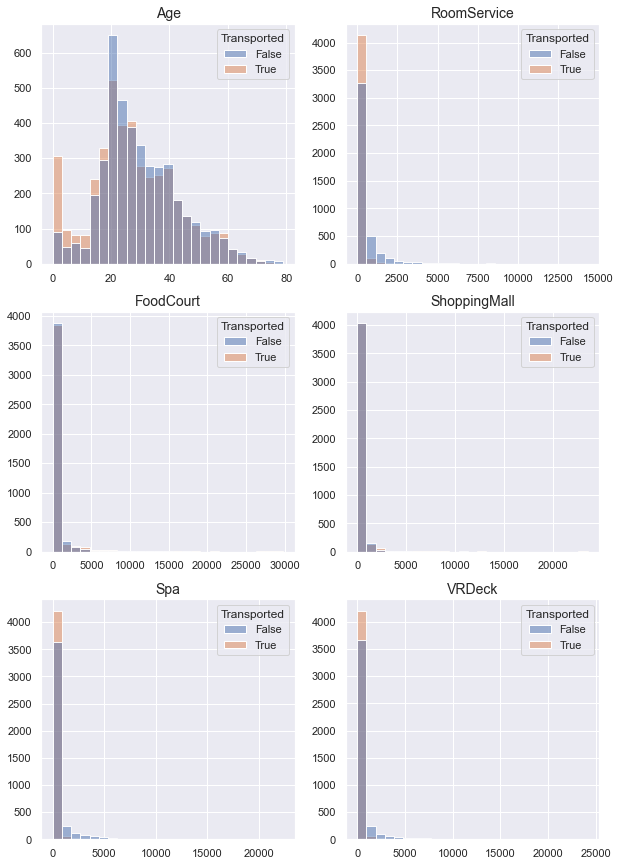

In [17]:
# columns of numerical features
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# visualise the relationship between the numerical features and the target
fig, axs = plt.subplots(3, 2, figsize=(10,15))

for i, col in enumerate(num_cols):
    ax = axs[i//2][i%2]
    sns.histplot(data=df_train, x=col, hue='Transported', bins=25, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(col, fontsize=14)

plt.show()

The five amenities were very similar. Most people do not purchase any of the amenities.

Maybe the five features can be integrated to become one feature representing total spend on all amenities, or become a categorical data suggesting whether a person purchase at any amenity or not.

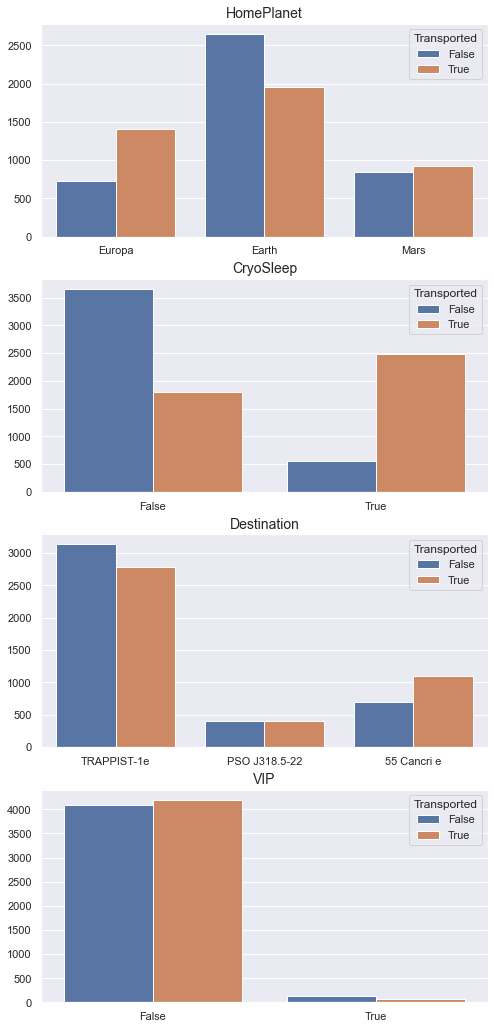

In [18]:
# columns of categorical features
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axs = plt.subplots(4, 1, figsize=(8,18))

for i, col in enumerate(cat_cols):
    ax = axs[i]
    sns.countplot(data=df_train, x=col, hue='Transported', ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(col, fontsize=14)

plt.show()

The `VIP` feature seems to have little relationship with the target. Maybe removing it would be better.

In [21]:
# explore the distribution of the target
df_train['Transported'].value_counts()/df_train['Transported'].value_counts().sum()

True     0.503624
False    0.496376
Name: Transported, dtype: float64

# Feature Engineering (creating new features based on existing ones)

In [27]:
# extract group information from PassengerId

df_train['GroupId'] = df_train['PassengerId'].apply(lambda x: x[:4])
df_train['GroupNo'] = df_train['PassengerId'].apply(lambda x: x[5:])

df_test['GroupId'] = df_test['PassengerId'].apply(lambda x: x[:4])
df_test['GroupNo'] = df_test['PassengerId'].apply(lambda x: x[5:])

In [32]:
df_train['Cabin'].mode()

0    G/734/S
dtype: object

In [34]:
# extract deck, num and side from Cabin
df_train['Cabin'].fillna('#/#/#', inplace=True)
df_test['Cabin'].fillna('#/#/#', inplace=True)

df_train['Deck'] = df_train['Cabin'].apply(lambda x: x.split('/')[0])
df_train['Num'] = df_train['Cabin'].apply(lambda x: x.split('/')[1])
df_train['Side'] = df_train['Cabin'].apply(lambda x: x.split('/')[2])

df_test['Deck'] = df_test['Cabin'].apply(lambda x: x.split('/')[0])
df_test['Num'] = df_test['Cabin'].apply(lambda x: x.split('/')[1])
df_test['Side'] = df_test['Cabin'].apply(lambda x: x.split('/')[2])

In [ ]:
# extract family name from Name
df_train['Name'].fillna('')

# Data cleaning

In [19]:
# check for duplicates
print(df_train.duplicated().sum(), df_test.duplicated().sum())

0 0


In [ ]:
# missing values
print("Total number of missing value in the training set is", sum(df_train.isna().sum()))
print(df_train.isna().sum())

print("\nTotal number of missing value in the test set is", sum(df_test.isna().sum()))
print(df_test.isna().sum())

Total number of missing value in the training set is 2324
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Total number of missing value in the test set is 1117
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [ ]:
# visualise the count of missing value for each column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

sns.barplot(x=df_train.isna().sum().values, y=df_train.columns, ax=ax1)
sns.barplot(x=df_test.isna().sum().values, y=df_test.columns, ax=ax2)

ax1.set_title('missing value counts for training set')
ax2.set_title('missing value counts for test set')

plt.show()

In [ ]:
# number of rows with at least one missing value
df_train[df_train.isna().any(axis=1)].shape[0]

In [ ]:
# use median to impute missing values (can also use SimpleImputer in skilearn module)
for col in num_cols:
    df_train[col].fillna(df_train[col].median(), inplace=True)
    df_test[col].fillna(df_test[col].median(), inplace=True)

In [ ]:
# number of rows with missing values after the imputation
print("Number of rows", df_train[df_train.isna().any(axis=1)].shape[0])

# by columns
print("\nBy columns")
print(df_train.isna().sum())

print("\n\nNumber of rows", df_test[df_test.isna().any(axis=1)].shape[0])
print("\nBy columns")
print(df_test.isna().sum())

In [ ]:
# use mode to impute missing values for categorical data
for col in cat_cols:
    df_train[col].fillna(df_train[col].mode()[0], inplace=True)
    df_test[col].fillna(df_test[col].mode()[0], inplace=True)

In [ ]:
# number of rows with missing values after the imputation
print("Number of rows", df_train[df_train.isna().any(axis=1)].shape[0])
print("Number of rows", df_test[df_test.isna().any(axis=1)].shape[0])

In [ ]:
# use LabelEncoder to encode categorical values
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_cols:
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)
    
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])

In [ ]:
df_train.dtypes

In [ ]:
df_train[['PassengerId', 'HomePlanet', 'Cabin','Destination','Name']] = df_train[['PassengerId', 'HomePlanet', 'Cabin','Destination','Name']].astype(str)
df_train[['CryoSleep', 'VIP']] = df_train[['CryoSleep', 'VIP']].astype(bool)

df_train.dtypes